In [1]:
import sxs
import spherical_functions as sf
import quaternion
import qnmfits
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from qnmfits import read_waveforms

### The `sxs` package lets us easily load SXS waveforms:

In [3]:
h = sxs.load('SXS:BBH:0305/Lev/rhOverM', extrapolation_order=2)
type(h)

Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


sxs.waveforms.waveform_modes.WaveformModes

The returned object is an sxs `WaveformModes` object. Converting to a scri `WaveformModes` object allows us to use lots of handy methods (see the `scri` documentation [here](https://scri.readthedocs.io/en/latest/_autosummary/scri.html#scri.WaveformModes)).

In [4]:
h = read_waveforms.sxs_to_scri_WM(h)
type(h)

scri.waveform_modes.WaveformModes

In [5]:
# We can also easily load metadata associated with the simulation
metadata = sxs.load('SXS:BBH:0305/Lev/metadata.json')

M = metadata.remnant_mass
chi_f = metadata.remnant_dimensionless_spin
chi = np.linalg.norm(chi_f)

Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json


One can also load preloaded data and metada using 
`scri.SpEC.read_from_h5('/path/to/rhOverM_Asymptotic_GeometricUnits_CoM_0305.h5/Extrapolated_N2.dir')`
and
`sxs.metadata.Metadata.from_file('/path/to/metadata_0305.txt', cache_json=False)`


Prepare the waveform for fitting by:
1) shifting the peak to be at $t=0M$,\
2) aligning the remnants spin with $+\hat{z}$, and \
3) cutting off any times in which we are not interested. 

In [6]:
# Shift peak of waveform to be at t=0M.
trim_ind = h.max_norm_index()
h.t -= h.t[trim_ind]

# If needed, rotate waveform so remnant spin is aligned with z-axis to get best fit 
th_z = np.arccos(chi_f[2]/np.linalg.norm(chi_f))
r_dir = np.cross([0,0,1],chi_f)
r_dir = th_z * r_dir / np.linalg.norm(r_dir)
q = quaternion.from_rotation_vector(-r_dir)
h.rotate_physical_system(q);

# Cut off waveform for times greater than 90M 
h_shifted = h.copy()[np.argmin(abs(h.t - 0.)):np.argmin(abs(h.t - 90))+1,:]

### Perform a seven overtone fit to the $h_{22}$ mode at $t_0 = t_{\mathrm{peak}}$ using the `qnmfits` package:

In [7]:
qnms = [(2,2,n,1) for n in range(7+1)]
t_0 = 0.

best_fit = qnmfits.fit(
    h_shifted,
    chi, 
    M,
    qnms,
    spherical_modes=[(2,2)],
    t_0=t_0
)

In [8]:
best_fit

{(2, 2, 0, 1): (0.14437528321368479+0.9515425435474277j),
 (2, 2, 1, 1): (3.0610426591889515-2.7093762966256953j),
 (2, 2, 2, 1): (-10.246299728811739+3.443272406056168j),
 (2, 2, 3, 1): (20.418309082400423-6.800353403449371j),
 (2, 2, 4, 1): (-26.115570479398155+15.832247758866057j),
 (2, 2, 5, 1): (18.14728849794662-20.10762901037941j),
 (2, 2, 6, 1): (-5.778945161898617+11.789713020709634j),
 (2, 2, 7, 1): (0.7092756681527439-2.59404466871331j)}

From this, one can build an analytical ringdown waveform with the `best_fit` amplitudes and calculate the mismatch over all modes.

In [9]:
Q = qnmfits.qnm_modes_as(chi, M, best_fit, h_shifted, t_0=0., t_ref=0.)

In [10]:
qnmfits.mismatch(h_shifted, Q, 0., 90., spherical_modes=None)

0.2965395561923747

/Users/eliot/Documents/Research/Ringdown/sxs-collaboration/qnmfits/.conda/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/eliot/Documents/Research/Ringdown/sxs-collaboration/qnmfits/.conda/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


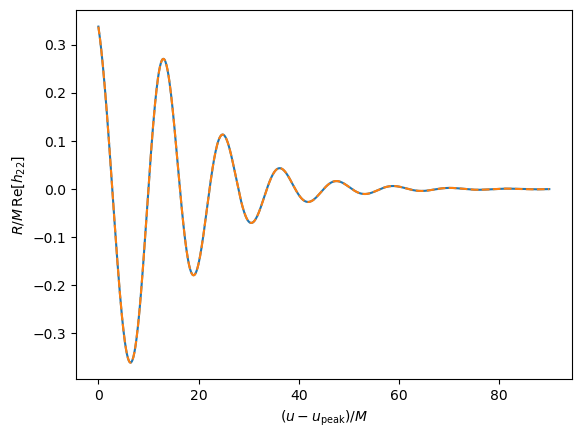

In [11]:
plt.xlabel(r'$\left(u-u_{\mathrm{peak}}\right)/M$')
plt.ylabel(r'$R/M\,\mathrm{Re}[h_{22}]$')

plt.plot(h_shifted.t, h_shifted.data[:,h_shifted.index(2,2).real])
plt.plot(Q.t, Q.data[:,Q.index(2,2)].real, '--')
plt.show()

### Perform a simultaneous fit for seven overtones and remnant spin and mass:

In [12]:
chi_fit, M_fit, qnm_fits, _ = qnmfits.fit_chi_M_and_modes(h_shifted, qnms, t_0=0., maxiter=10000, xtol=1e-8, ftol=1e-8)

In [13]:
qnm_fits

{(2, 2, 0, 1): (0.13711595634702647+0.9530714247817789j),
 (2, 2, 1, 1): (3.1535602664554285-2.7199137139825136j),
 (2, 2, 2, 1): (-10.862778496776663+3.601505025263377j),
 (2, 2, 3, 1): (22.713321500884884-7.916367087914363j),
 (2, 2, 4, 1): (-30.53867495252515+19.57553756680446j),
 (2, 2, 5, 1): (22.287858857659813-25.710967840632406j),
 (2, 2, 6, 1): (-7.603235463930614+15.568519044791492j),
 (2, 2, 7, 1): (1.0526848329292002-3.5459469072572967j)}

Calculate the error as defined in Eq. 31 of https://arxiv.org/pdf/2110.15922

In [14]:
print(np.sqrt(((M_fit-M)/M)**2.0+(chi_fit-chi)**2.0))

0.0003573980631390952


Build the analytical waveform with the best fit modes and calculate the mismatch over all modes.

In [15]:
Q = qnmfits.qnm_modes_as(chi_fit, M_fit, qnm_fits, h_shifted, t_0=0., t_ref=0.)

In [16]:
qnmfits.mismatch(h_shifted, Q, 0., 90.)

0.2965396761227119